In [1]:
from langchain_text_splitters import CharacterTextSplitter
from unstructured.partition.pdf import partition_pdf

In [2]:
# Extract elements from PDF
def extract_pdf_elements(path, fname):
    """
    Extract images, tables, and chunk text from a PDF file.
    path: File path, which is used to dump images (.jpg)
    fname: File name
    """
    return partition_pdf(
        filename=path + fname,
        extract_images_in_pdf=False,
        infer_table_structure=True,
        chunking_strategy="by_title",
        max_characters=4000,
        new_after_n_chars=3800,
        combine_text_under_n_chars=2000,
        image_output_dir_path=path,
    )


# Categorize elements by type
def categorize_elements(raw_pdf_elements):
    """
    Categorize extracted elements from a PDF into tables and texts.
    raw_pdf_elements: List of unstructured.documents.elements
    """
    tables = []
    texts = []
    for element in raw_pdf_elements:
        if "unstructured.documents.elements.Table" in str(type(element)):
            tables.append(str(element))
        elif "unstructured.documents.elements.CompositeElement" in str(type(element)):
            texts.append(str(element))
    return texts, tables


In [3]:
fpath = "G:\\cj\\"
fname = "cj.pdf"

In [4]:
raw_pdf_elements = extract_pdf_elements(fpath, fname)

This function will be deprecated in a future release and `unstructured` will simply use the DEFAULT_MODEL from `unstructured_inference.model.base` to set default model name


config.json:   0%|          | 0.00/1.47k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/115M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/46.8M [00:00<?, ?B/s]

Some weights of the model checkpoint at microsoft/table-transformer-structure-recognition were not used when initializing TableTransformerForObjectDetection: ['model.backbone.conv_encoder.model.layer2.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer3.0.downsample.1.num_batches_tracked', 'model.backbone.conv_encoder.model.layer4.0.downsample.1.num_batches_tracked']
- This IS expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TableTransformerForObjectDetection from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [5]:
# Get text, tables
texts, tables = categorize_elements(raw_pdf_elements)

In [6]:
text_splitter = CharacterTextSplitter.from_tiktoken_encoder(
    chunk_size=4000, chunk_overlap=0
)
joined_texts = " ".join(texts)
texts_4k_token = text_splitter.split_text(joined_texts)

Created a chunk of size 4075, which is longer than the specified 4000


In [8]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_groq import ChatGroq

import os
groq_api_key = os.getenv("GROQ-API_KEY")


# Generate summaries of text elements
def generate_text_summaries(texts, tables, summarize_texts=False):
    """
    Summarize text elements
    texts: List of str
    tables: List of str
    summarize_texts: Bool to summarize texts
    """

    # Prompt
    prompt_text = """You are an assistant tasked with summarizing tables and text for retrieval. \
    These summaries will be embedded and used to retrieve the raw text or table elements. \
    Give a concise summary of the table or text that is well optimized for retrieval. Table or text: {element} """
    prompt = ChatPromptTemplate.from_template(prompt_text)

    # Text summary chain
    model = ChatGroq(model="mixtral-8x7b-32768", temperature=0)
    summarize_chain = {"element": lambda x: x} | prompt | model | StrOutputParser()

    # Initialize empty summaries
    text_summaries = []
    table_summaries = []

    # Apply to text if texts are provided and summarization is requested
    if texts and summarize_texts:
        text_summaries = summarize_chain.batch(texts, {"max_concurrency": 5})
    elif texts:
        text_summaries = texts

    # Apply to tables if tables are provided
    if tables:
        table_summaries = summarize_chain.batch(tables, {"max_concurrency": 5})

    return text_summaries, table_summaries


# Get text, table summaries
text_summaries, table_summaries = generate_text_summaries(
    texts_4k_token, tables, summarize_texts=True
)

In [9]:
table_summaries

['"Prompt encouraging user to type their email address and subscribe to a service or newsletter."']

In [10]:
text_summaries

["This summary covers Jamin Ball's Clouded Judgement newsletter from November 10, 23. The main topics include:\n\n1. OpenAI updates: OpenAI has announced increased context windows and decreased costs for their GPT 4 Turbo model, making it more cost-effective for AI experimentation and production.\n2. Datadog's positive impact on software stocks: Datadog's quarterly earnings showed optimizations easing up and a healthy start to Q4, leading to a ~30% increase in their stock price. This positive commentary suggests a potential turn in the corner for the software industry.\n3. Quarterly reports summary: A table summarizing the revenue, revenue growth, and guidance for various software companies, including On24, Squarespace, Jamf, Kaltura, CS Disco, 2U, Olo, Alteryx, RingCentral, Klaviyo, Datadog, Amplitude, Hubspot, BigCommerce, Twilio, and Wix.com.\n4. Top 10 EV/NTM revenue multiples: A list of the top 10 software companies with their EV/NTM revenue multiples, gross margins, operating mar

In [26]:
fpath = "G:\\cj\\"
# fname = "cj.pdf"

In [28]:
import base64
import os
from langchain_community.chat_models import ChatOllama
import ollama

from langchain_core.messages import HumanMessage


def encode_image(image_path):
    """Getting the base64 string"""
    with open(image_path, "rb") as image_file:
        return base64.b64encode(image_file.read()).decode("utf-8")


def image_summarize(base64_image,prompt):
    """Make image summary"""
    msg = ollama.generate(
            	model="llava:7b",
            	prompt=prompt
                )
    return msg['response']


def generate_img_summaries(path):
    """
    Generate summaries and base64 encoded strings for images
    path: Path to list of .jpg files extracted by Unstructured
    """

    # Store base64 encoded images
    img_base64_list = []

    # Store image summaries
    image_summaries = []

    # Prompt
    prompt = """You are an assistant tasked with summarizing images for retrieval. \
    These summaries will be embedded and used to retrieve the raw image. \
    Give a concise summary of the image that is well optimized for retrieval."""

    # Apply to images
    for img_file in sorted(os.listdir(path)):
        if img_file.endswith(".jpg"):
            img_path = os.path.join(path, img_file)
            base64_image = encode_image(img_path)
            img_base64_list.append(base64_image)
            image_summaries.append(image_summarize(base64_image, prompt))

    return img_base64_list, image_summaries


# Image summaries
img_base64_list, image_summaries = generate_img_summaries(fpath)

In [29]:
print(img_base64_list)
print(image_summaries)

['/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAgGBgcGBQgHBwcJCQgKDBQNDAsLDBkSEw8UHRofHh0aHBwgJC4nICIsIxwcKDcpLDAxNDQ0Hyc5PTgyPC4zNDL/2wBDAQkJCQwLDBgNDRgyIRwhMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjIyMjL/wAARCAL0Be0DASIAAhEBAxEB/8QAHwAAAQUBAQEBAQEAAAAAAAAAAAECAwQFBgcICQoL/8QAtRAAAgEDAwIEAwUFBAQAAAF9AQIDAAQRBRIhMUEGE1FhByJxFDKBkaEII0KxwRVS0fAkM2JyggkKFhcYGRolJicoKSo0NTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqDhIWGh4iJipKTlJWWl5iZmqKjpKWmp6ipqrKztLW2t7i5usLDxMXGx8jJytLT1NXW19jZ2uHi4+Tl5ufo6erx8vP09fb3+Pn6/8QAHwEAAwEBAQEBAQEBAQAAAAAAAAECAwQFBgcICQoL/8QAtREAAgECBAQDBAcFBAQAAQJ3AAECAxEEBSExBhJBUQdhcRMiMoEIFEKRobHBCSMzUvAVYnLRChYkNOEl8RcYGRomJygpKjU2Nzg5OkNERUZHSElKU1RVVldYWVpjZGVmZ2hpanN0dXZ3eHl6goOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4uPk5ebn6Onq8vP09fb3+Pn6/9oADAMBAAIRAxEAPwD34kAZJwKb50f/AD0X86jvP+POXH92mpbwsgzGvQdqAJvOi/56J/31R50X/PRfzqP7JB/zyX8qX7LD/wA8k/KgB/nR/wDPRfzo86P/AJ6L+dM+zRf880/Kj7NF/wA80/KgB/nRf89F/Ojzov8Anon/AH1TPssP/PNPypPskH

In [11]:
import ollama

res = ollama.chat(
	model="llava:7b",
	messages=[
		{
			'role': 'user',
			'content': 'Describe this image:',
			'images': ['C:/Users/mural/Desktop/pandas.jpg']
		}
	]
)

print(res['message']['content'])

 The image is a stylized, cartoon-like illustration. It features an anthropomorphic panda character standing in the foreground with a large bamboo stalk in its mouth. The panda is facing towards the viewer and appears to be sitting on a grassy area. Behind the panda, there are tall bamboo plants framing the scene. In the background, there's a simple sky and a clear, blue sky. The overall atmosphere of the image suggests a peaceful, natural setting. 


In [12]:
from langchain_community.chat_models import ChatOllama

In [16]:
from langchain_community.chat_models import ChatOllama
import ollama
res = ollama.generate(model="llava:7b", prompt='Describe this image',images=['C:/Users/mural/Desktop/pandas.jpg'])
print(res['response'], end='', flush=True)

 The image shows an anthropomorphic panda character sitting on a grassy area surrounded by bamboo. The panda is wearing a black and white striped shirt with a round neckline, giving it a human-like appearance. It's holding a piece of food in its hand, suggesting that it might be enjoying a meal or about to eat. The background is filled with bamboo stalks, creating a natural setting, and there are green plants and trees visible. The sky above appears to be a clear blue, indicating good weather conditions. There is no text on the image. The style of the image suggests that it could be part of an animated film or character design. 

In [30]:
import uuid

from langchain.retrievers.multi_vector import MultiVectorRetriever
from langchain.storage import InMemoryStore
from langchain_community.vectorstores import Chroma
from langchain_core.documents import Document
from langchain_community.embeddings import OllamaEmbeddings


def create_multi_vector_retriever(
    vectorstore, text_summaries, texts, table_summaries, tables, image_summaries, images
):
    """
    Create retriever that indexes summaries, but returns raw images or texts
    """

    # Initialize the storage layer
    store = InMemoryStore()
    id_key = "doc_id"

    # Create the multi-vector retriever
    retriever = MultiVectorRetriever(
        vectorstore=vectorstore,
        docstore=store,
        id_key=id_key,
    )

    # Helper function to add documents to the vectorstore and docstore
    def add_documents(retriever, doc_summaries, doc_contents):
        doc_ids = [str(uuid.uuid4()) for _ in doc_contents]
        summary_docs = [
            Document(page_content=s, metadata={id_key: doc_ids[i]})
            for i, s in enumerate(doc_summaries)
        ]
        retriever.vectorstore.add_documents(summary_docs)
        retriever.docstore.mset(list(zip(doc_ids, doc_contents)))

    # Add texts, tables, and images
    # Check that text_summaries is not empty before adding
    if text_summaries:
        add_documents(retriever, text_summaries, texts)
    # Check that table_summaries is not empty before adding
    if table_summaries:
        add_documents(retriever, table_summaries, tables)
    # Check that image_summaries is not empty before adding
    if image_summaries:
        add_documents(retriever, image_summaries, images)

    return retriever


# The vectorstore to use to index the summaries
vectorstore = Chroma(
    collection_name="mm_rag_cj_blog", embedding_function=OllamaEmbeddings(model="nomic-embed-text:latest")
)

# Create retriever
retriever_multi_vector_img = create_multi_vector_retriever(
    vectorstore,
    text_summaries,
    texts,
    table_summaries,
    tables,
    image_summaries,
    img_base64_list,
)

In [33]:
import io
import re

from IPython.display import HTML, display
from langchain_core.runnables import RunnableLambda, RunnablePassthrough
from PIL import Image
from langchain_community.chat_models import ChatOllama


def plt_img_base64(img_base64):
    """Disply base64 encoded string as image"""
    # Create an HTML img tag with the base64 string as the source
    image_html = f'<img src="data:image/jpeg;base64,{img_base64}" />'
    # Display the image by rendering the HTML
    display(HTML(image_html))


def looks_like_base64(sb):
    """Check if the string looks like base64"""
    return re.match("^[A-Za-z0-9+/]+[=]{0,2}$", sb) is not None


def is_image_data(b64data):
    """
    Check if the base64 data is an image by looking at the start of the data
    """
    image_signatures = {
        b"\xff\xd8\xff": "jpg",
        b"\x89\x50\x4e\x47\x0d\x0a\x1a\x0a": "png",
        b"\x47\x49\x46\x38": "gif",
        b"\x52\x49\x46\x46": "webp",
    }
    try:
        header = base64.b64decode(b64data)[:8]  # Decode and get the first 8 bytes
        for sig, format in image_signatures.items():
            if header.startswith(sig):
                return True
        return False
    except Exception:
        return False


def resize_base64_image(base64_string, size=(128, 128)):
    """
    Resize an image encoded as a Base64 string
    """
    # Decode the Base64 string
    img_data = base64.b64decode(base64_string)
    img = Image.open(io.BytesIO(img_data))

    # Resize the image
    resized_img = img.resize(size, Image.LANCZOS)

    # Save the resized image to a bytes buffer
    buffered = io.BytesIO()
    resized_img.save(buffered, format=img.format)

    # Encode the resized image to Base64
    return base64.b64encode(buffered.getvalue()).decode("utf-8")


def split_image_text_types(docs):
    """
    Split base64-encoded images and texts
    """
    b64_images = []
    texts = []
    for doc in docs:
        # Check if the document is of type Document and extract page_content if so
        if isinstance(doc, Document):
            doc = doc.page_content
        if looks_like_base64(doc) and is_image_data(doc):
            doc = resize_base64_image(doc, size=(1300, 600))
            b64_images.append(doc)
        else:
            texts.append(doc)
    return {"images": b64_images, "texts": texts}


def img_prompt_func(data_dict):
    """
    Join the context into a single string
    """
    formatted_texts = "\n".join(data_dict["context"]["texts"])
    messages = []

    # Adding image(s) to the messages if present
    if data_dict["context"]["images"]:
        for image in data_dict["context"]["images"]:
            image_message = {
                "type": "image_url",
                "image_url": {"url": f"data:image/jpeg;base64,{image}"},
            }
            messages.append(image_message)

    # Adding the text for analysis
    text_message = {
        "type": "text",
        "text": (
            "You are financial analyst tasking with providing investment advice.\n"
            "You will be given a mixed of text, tables, and image(s) usually of charts or graphs.\n"
            "Use this information to provide investment advice related to the user question. \n"
            f"User-provided question: {data_dict['question']}\n\n"
            "Text and / or tables:\n"
            f"{formatted_texts}"
        ),
    }
    messages.append(text_message)
    return [HumanMessage(content=messages)]


def multi_modal_rag_chain(retriever):
    """
    Multi-modal RAG chain
    """

    # Multi-modal LLM
    model = ChatOllama(model="llava:7b")

    # RAG pipeline
    chain = (
        {
            "context": retriever | RunnableLambda(split_image_text_types),
            "question": RunnablePassthrough(),
        }
        | RunnableLambda(img_prompt_func)
        | model
        | StrOutputParser()
    )

    return chain


# Create RAG chain
chain_multimodal_rag = multi_modal_rag_chain(retriever_multi_vector_img)

In [34]:
# Check retrieval
query = "Give me company names that are interesting investments based on EV / NTM and NTM rev growth. Consider EV / NTM multiples vs historical?"
docs = retriever_multi_vector_img.invoke(query, limit=6)

# We get 4 docs
len(docs)

4

In [35]:
# Check retrieval
query = "What are the EV / NTM and NTM rev growth for MongoDB, Cloudflare, and Datadog?"
docs = retriever_multi_vector_img.invoke(query, limit=6)

# We get 4 docs
len(docs)

4

In [38]:
# We get back relevant images
plt_img_base64(docs[0])


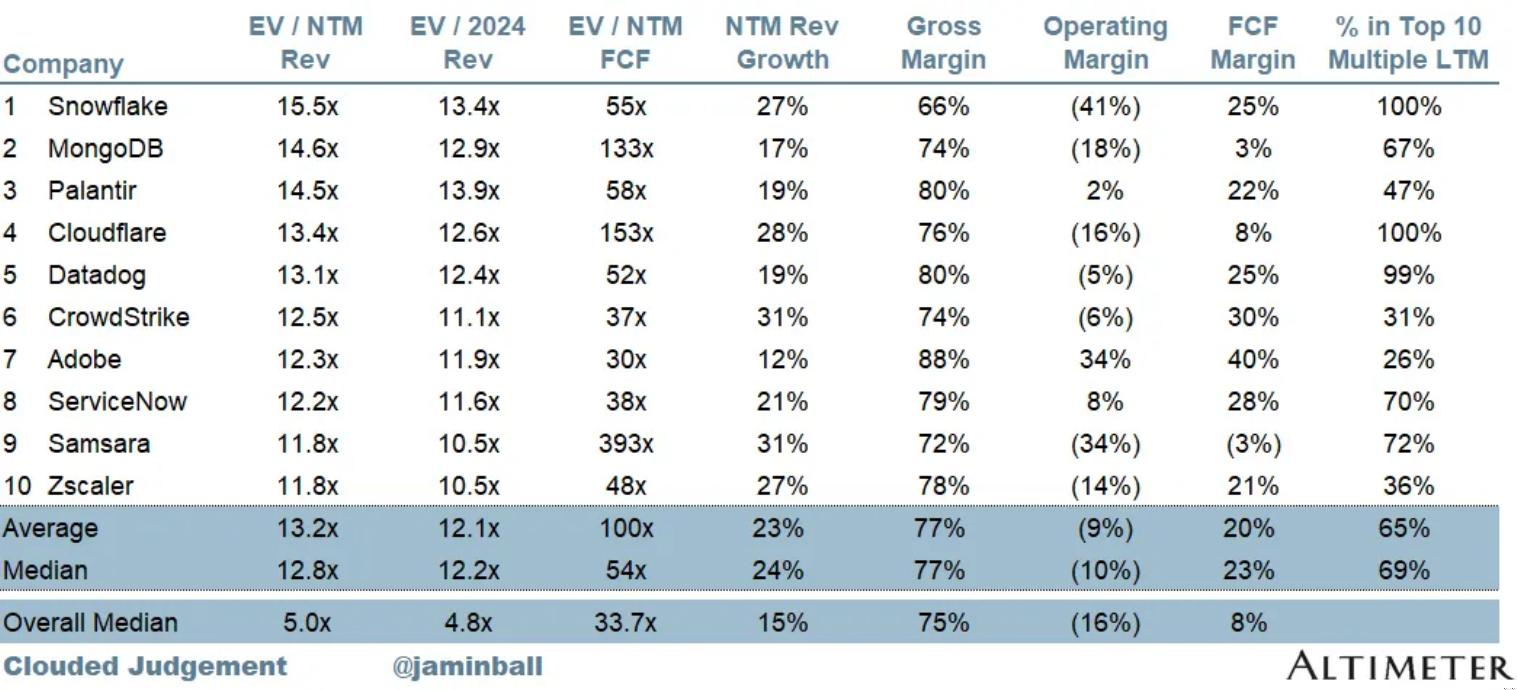

In [39]:
plt_img_base64(img_base64_list[3])

In [40]:
image_summaries[3]

' The image features a person wearing a blue jacket standing in front of a building. The person has their head turned slightly to the side, and they appear to be looking at something out of frame. The building behind them has a visible sign on it, but the text on the sign is not legible in the image. '

In [42]:
# Run RAG chain
query = "What are the EV / NTM and NTM rev growth for MongoDB, Cloudflare, and Datadog?"
chain_multimodal_rag.invoke(query)

' stable through Q3.”\n\nOverall, it seems that Datadog is experiencing an improvement in customer activity, with optimizations easing up and a healthy start to Q4. This could be due to a number of factors such as improvements in the economy, changes in customer behavior or preferences, and successful efforts by Datadog to address customer needs and concerns. '

In [43]:
import base64

image_path = "C:/Users/mural/Desktop/pandas.jpg"
with open(image_path, "rb") as image_file:
    base64_string = base64.b64encode(image_file.read()).decode('utf-8')

print(base64_string)

/9j/4AAQSkZJRgABAQAAAQABAAD/2wBDAAQDAwQDAwQEBAQFBQQFBwsHBwYGBw4KCggLEA4RERAOEA8SFBoWEhMYEw8QFh8XGBsbHR0dERYgIh8cIhocHRz/2wBDAQUFBQcGBw0HBw0cEhASHBwcHBwcHBwcHBwcHBwcHBwcHBwcHBwcHBwcHBwcHBwcHBwcHBwcHBwcHBwcHBwcHBz/wgARCAH+A/wDAREAAhEBAxEB/8QAHQAAAAYDAQAAAAAAAAAAAAAAAAMEBQYHAQIICf/EABsBAQEAAwEBAQAAAAAAAAAAAAABAgMEBQYH/9oADAMBAAIQAxAAAAC4+3ylGasPPzpv4TOzuavGuRDlwqn2djjikPM04dcG9LLtf9L1vW1lMgMmQAgAAAAAAAAAAAAAAAAAAAAAAAADJhQgAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABjG6aKn1zOxiN8bBvi8ot5NP6JFebC0vsbPPpsRSXC0n+UZJOEn7cre+zxefpceK/wAx22dw4v22oqcPqpdf1+GEj+m8n/C7rI8uVz6StPWzWxZnfhK9GPRX0uva2nPHzrn4jKyeerteMK5Mat9vY84JFywngwiHo5dlfp2D/umTIDMCgZAAAAAAAAAAAAAAAAAAAAAbrqgMy4swAAAAAYAA0lUzJbr3IMtZeeAuIMgAAAAAAAAAAAAAAAAAAAAAAACKfM2IfKZwTRgNdQdEuz6pOPqoAFf8eVeflOUv2yYfpUrL4azHtnKHDnZfmYyvbW/ZkZ9JjfP2etNz2JePef8A5fZKeSV76ecQ7JjJevoYUn5mXdP22jZaL8TOK/FSyufIacYHoVb721/0SU8hP5+uK996+/UMZN045MmYyBQZAAAAAAAAAAAAAAAAAAAGxuu64NULTAAAAAwKsdirVuccNxErLjkFdTcc7M5YE5YR/dzJstYAAAAAAAAAAAAAAAAAAAAAAjPzdpf4aos4/deUL1Y3X9Ws